In [12]:
# tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import logging
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

# data
from neuralforecast.utils import AirPassengersDF
# forecast
from neuralforecast import NeuralForecast
# models
from neuralforecast.models import NBEATS, NHITS, RNN, LSTM

import torch
torch.set_float32_matmul_precision('medium')

# data

In [13]:
# Split data and declare panel dataset
Y_df = AirPassengersDF
Y_train_df = Y_df[Y_df.ds <= "1959-12-31"]
Y_test_df = Y_df[Y_df.ds > "1959-12-31"]

print(Y_df.head(), "\n")
print(Y_df.shape, "\n")
print(Y_df["unique_id"].value_counts(), "\n")
print(Y_train_df.shape)
print(Y_test_df.shape)

   unique_id         ds      y
0        1.0 1949-01-31  112.0
1        1.0 1949-02-28  118.0
2        1.0 1949-03-31  132.0
3        1.0 1949-04-30  129.0
4        1.0 1949-05-31  121.0 

(144, 3) 

unique_id
1.0    144
Name: count, dtype: int64 

(132, 3)
(12, 3)


In [14]:
Y_train_df.head()

,unique_id,ds,y
0,1.0,1949-01-31,112.0
1,1.0,1949-02-28,118.0
2,1.0,1949-03-31,132.0
3,1.0,1949-04-30,129.0
4,1.0,1949-05-31,121.0


In [15]:
Y_test_df.head()

,unique_id,ds,y
132,1.0,1960-01-31,417.0
133,1.0,1960-02-29,391.0
134,1.0,1960-03-31,419.0
135,1.0,1960-04-30,461.0
136,1.0,1960-05-31,472.0


# model fit

In [16]:
# forecast length
horizon = len(Y_test_df)

# model
nf = NeuralForecast(
    models = [
        LSTM(
            h = horizon, 
            max_steps = 500, 
            scaler_type = "standard",
            encoder_hidden_size = 64, 
            decoder_hidden_size = 64
        ),
        # NBEATS(
        #     input_size = 2 * horizon, 
        #     h = horizon, 
        #     max_steps = 50
        # ),
        # NHITS(
        #     input_size = 2 * horizon, 
        #     h = horizon, 
        #     max_steps = 100, 
        #     n_freq_downsample = [2, 1, 1]
        # ),
    ], 
    freq = "M"
)

# model training
nf.fit(df = Y_train_df)

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# model predict

In [19]:
Y_hat_df = nf.predict().reset_index()
Y_hat_df

Predicting: 0it [00:00, ?it/s]

,unique_id,ds,LSTM
0,1.0,1960-01-31,416.811829
1,1.0,1960-02-29,431.704224
2,1.0,1960-03-31,421.217896
3,1.0,1960-04-30,421.195374
4,1.0,1960-05-31,468.277161
5,1.0,1960-06-30,529.506714
6,1.0,1960-07-31,590.911011
7,1.0,1960-08-31,568.070312
8,1.0,1960-09-30,502.768005
9,1.0,1960-10-31,433.618286


# plot_predictions

In [20]:
# test and predictions data
Y_hat_df = Y_test_df.merge(Y_hat_df, how = "left", on = ["unique_id", "ds"])
Y_hat_df

,unique_id,ds,y,LSTM
0,1.0,1960-01-31,417.0,416.811829
1,1.0,1960-02-29,391.0,431.704224
2,1.0,1960-03-31,419.0,421.217896
3,1.0,1960-04-30,461.0,421.195374
4,1.0,1960-05-31,472.0,468.277161
5,1.0,1960-06-30,535.0,529.506714
6,1.0,1960-07-31,622.0,590.911011
7,1.0,1960-08-31,606.0,568.070312
8,1.0,1960-09-30,508.0,502.768005
9,1.0,1960-10-31,461.0,433.618286


In [23]:
plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index("ds")
print(plot_df.head(13))
print(plot_df.tail(13))

            unique_id      y  LSTM
ds                                
1949-01-31        1.0  112.0   NaN
1949-02-28        1.0  118.0   NaN
1949-03-31        1.0  132.0   NaN
1949-04-30        1.0  129.0   NaN
1949-05-31        1.0  121.0   NaN
1949-06-30        1.0  135.0   NaN
1949-07-31        1.0  148.0   NaN
1949-08-31        1.0  148.0   NaN
1949-09-30        1.0  136.0   NaN
1949-10-31        1.0  119.0   NaN
1949-11-30        1.0  104.0   NaN
1949-12-31        1.0  118.0   NaN
1950-01-31        1.0  115.0   NaN
            unique_id      y        LSTM
ds                                      
1959-12-31        1.0  405.0         NaN
1960-01-31        1.0  417.0  416.811829
1960-02-29        1.0  391.0  431.704224
1960-03-31        1.0  419.0  421.217896
1960-04-30        1.0  461.0  421.195374
1960-05-31        1.0  472.0  468.277161
1960-06-30        1.0  535.0  529.506714
1960-07-31        1.0  622.0  590.911011
1960-08-31        1.0  606.0  568.070312
1960-09-30        1.0  5

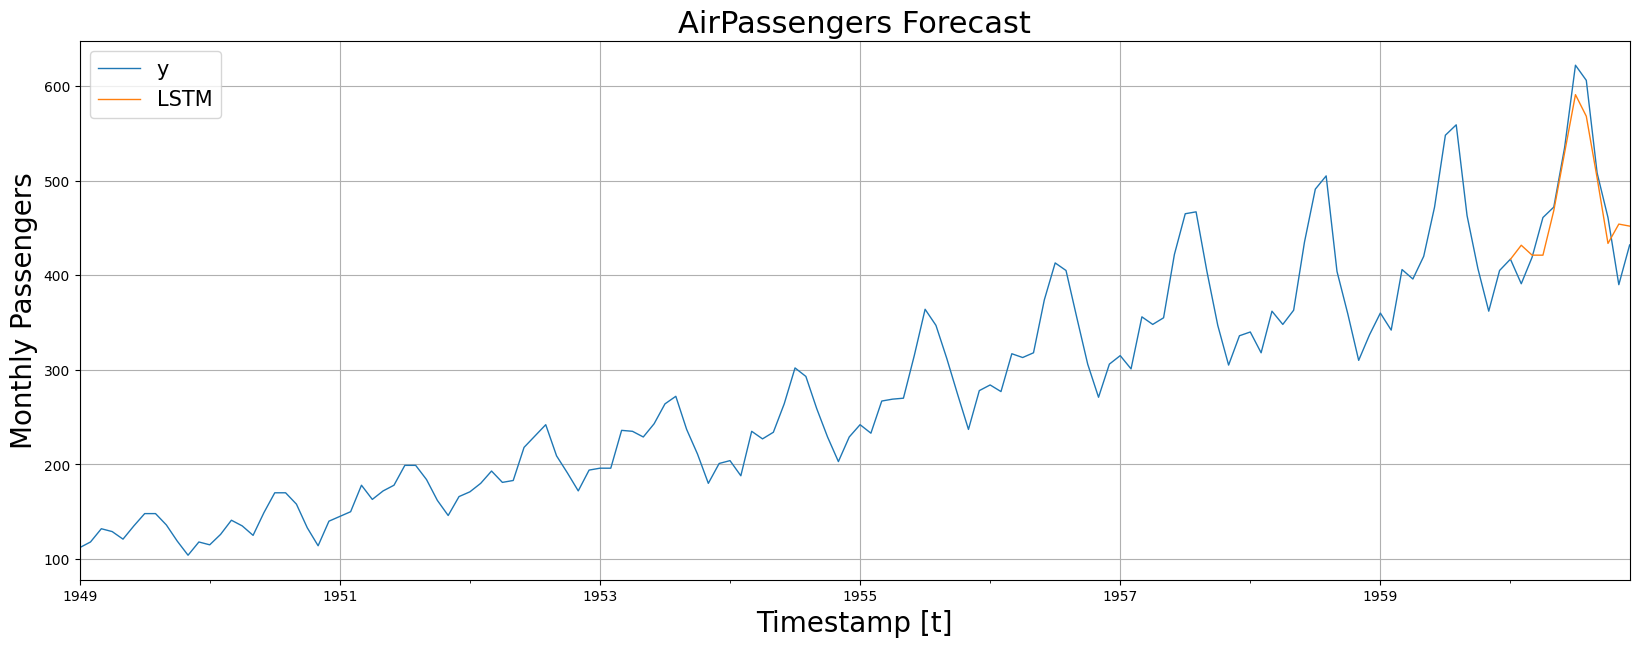

In [25]:
# plot
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
plot_df[["y", "LSTM"]].plot(ax = ax, linewidth = 1.0)
ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()